# **Mask R-CNN Instance Based Image Segmentation**

**Code:** Mask R-CNN for object detection and instance segmentation on Keras and TensorFlow, Waleed Abdulla, 2017, https://github.com/matterport/Mask_RCNN

**Paper:** K. He, G. Gkioxari, P. Dollár and R. Girshick, "Mask R-CNN," 2017 IEEE International Conference on Computer Vision (ICCV), Venice, 2017, pp. 2980-2988, doi: 10.1109/ICCV.2017.322.


## Import Libraries and Mount Drive

In [1]:
import warnings
import logging
warnings.filterwarnings("ignore")

In [2]:
import os,cv2
from skimage import io
from tqdm import tqdm
from scipy import stats
import shutil
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.measure import label, regionprops
import tensorflow as tf
from keras.models import *
import keras
tf.get_logger().setLevel(logging.ERROR)

from imgaug import augmenters as iaa
from datetime import timedelta
import datetime
import imageio
import math
import pytz
from pytz import timezone
import imagecodecs._imcd
from tifffile import imread

from root.Mask_RCNN.mrcnn.config import Config
from root.Mask_RCNN.mrcnn import utils
from root.Mask_RCNN.mrcnn import model as modellib
from root.Mask_RCNN.mrcnn import visualize
from root.Mask_RCNN.mrcnn import postprocessing
from root.Mask_RCNN.mrcnn.model import log
import nucleus

Using TensorFlow backend.


In [3]:
def gamma_img(gamma, img):
    gamma_cvt = np.zeros((256,1), dtype=np.uint8)
    for i in range(256):
        gamma_cvt[i][0] = 255*(float(i)/255)**(1.0/gamma)
    return cv2.LUT(img, gamma_cvt)

def reject_outliers(data, m=2):
    JoeGreen = np.mean(data)
    STD = np.std(data)
    data[(data -JoeGreen) > m*STD] = 0
    return data

# 1. Load and Process Images

In [4]:
path_home = "/home/acd13264yb/DDDog/Datasets/221206SoRa/"
# path_home = "../../../Datasets/221206SoRa/"

path_chip = ["Ctrl/60x_4x_Dapi_test_50nmSTP007/60x_4x_Dapi_test_50nmSTP007_XY",
             "VPA/VPA_555CTCF_488H3K27AC_DAPI_004/VPA_555CTCF_488H3K27AC_DAPI_004_XY"]
Chip_status = ["H3K27ac", "CTCF", "Hoechst"]

## 1.1 Unit16 -> Unit8 

/home/acd13264yb/DDDog/Datasets/221206SoRa/Ctrl/60x_4x_Dapi_test_50nmSTP007/60x_4x_Dapi_test_50nmSTP007_XY089.ome.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


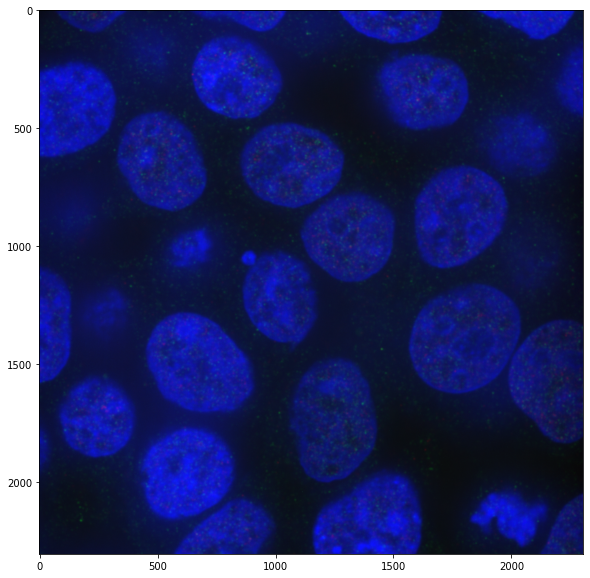

In [32]:
path = path_home+path_chip[0]+"089.ome.tif"
print(path)

img_origin = io.imread(path)
# img_uint8 = img_origin - img_origin.min()
# img_uint8 = img_uint8 / (img_uint8.max() - img_uint8.min())
# img_uint8 *= 255
# img_uint8 = img_uint8.astype(np.uint8)
b = img_origin[:,:,2]
img_hoechst = cv2.merge([b,b,b])
# img_hoechst = gamma_img(2, img_hoechst)

img_uint8 = io.imread(path)
img_uint8[img_uint8>255]=255
img_uint8 = img_uint8.astype(np.uint8)
b_uint8 = img_uint8[:,:,2]
img_hoechst_uint8 = cv2.merge([b_uint8,b_uint8,b_uint8])

plt.figure(figsize=(10,10))
plt.imshow(img_origin)

## 1.2 Denoise using UNet

In [22]:
# NW = '../../Datasets/weights/unet_noise_cell_line.hdf5'
# model = load_model(NW)

In [23]:
# img = cv2.resize(b, (512, 512), interpolation=cv2.INTER_CUBIC)
# img_new = np.asarray([img / 255.])
# img_new = np.expand_dims(img_new,3)

# result = model.predict(img_new)
# out = result[0,:,:,0]
# out = np.zeros(img_new.shape)
# out = 255*result[0,:,:,0].astype(np.uint8)
# imgDN = img - out
# imgDN[imgDN<0]=0
# imgDN = cv2.resize(imgDN, (2306, 2306), interpolation=cv2.INTER_CUBIC)

# plt.figure(figsize=(10,10))
# plt.subplot(1,3,1)
# plt.imshow(img)
# plt.subplot(1,3,2)
# plt.imshow(out)
# print(out.max())
# plt.subplot(1,3,3)
# plt.imshow(imgDN)

# 2. Configuration

In [24]:
class NucleusInferenceConfig(nucleus.NucleusConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MAX_DIM = 512

    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.3
    RPN_NMS_THRESHOLD = 0.2
    
    BACKBONE = "resnet50"
    
    MEAN_PIXEL = np.mean(img_hoechst,axis=(0,1))
    
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (100, 100)

# 3. Run the Network

In [25]:
Weights = "Kaggle"

In [26]:
#Change weight paths if different.
if Weights == "coco":
    weights_path = '../../Datasets/weights/mask_rcnn_coco.h5' 
elif Weights == "imagenet":
    weights_path = model.get_imagenet_weights()
elif Weights == "Kaggle":
    weights_path = '../../Datasets/weights/mask_rcnn_kaggle_v1.h5' 
elif Weights == "Storm_Tissue":
    weights_path = '../../Datasets/weights/mask_rcnn_nucleus_tissue.h5' 
elif Weights == "Storm_Cell":
    weights_path = '../../Datasets/weights/mask_rcnn_nucleus_cell.h5' 
elif Weights == "Select":
    weights_path = '../../Datasets/weights/select_weight.h5' 

## 3.1 Run Network

In [27]:
# Configurations
config = NucleusInferenceConfig()

# Create model
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=weights_path)

if Weights == "coco":
    model.load_weights(weights_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])
else:
    model.load_weights(weights_path, by_name=True)
    
result = model.detect([img_hoechst], verbose=0)[0]

Origin shape:  (2304, 2304, 3)
image                    shape: (2304, 2304, 3)       min:   18.00000  max:  223.00000  uint16
mask                     shape: (2304, 2304, 0)       min:             max:             float64
class_ids                shape: (0,)                  min:             max:             int32
bbox                     shape: (0, 4)                min:             max:             int32

*** No instances to display *** 



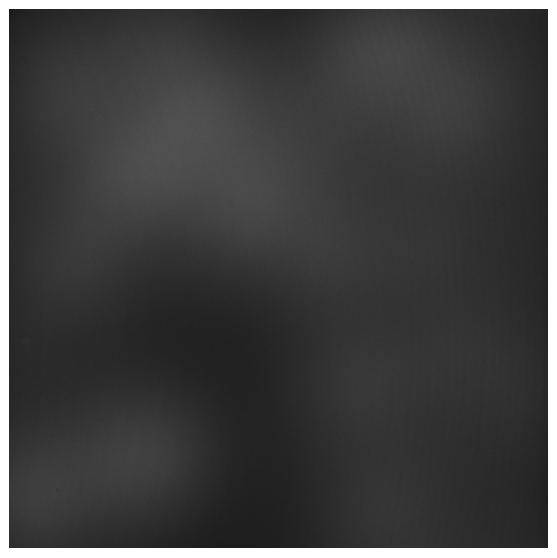

In [28]:
mask, bbox, class_ids = result["masks"], result["rois"], result["class_ids"]
print("Origin shape: ", img_origin.shape)
log("image", img_hoechst)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(img_hoechst_uint8, bbox, mask, class_ids, ["BG","nucleus"], figsize=(10, 10))

## 4. post processing

### 4.1 remove outliers by roundness

In [14]:
def compute_roundness(label_image):
    contours, hierarchy = cv2.findContours(np.array(label_image, dtype=np.uint8), cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE)
    a = cv2.contourArea(contours[0]) * 4 * math.pi
    b = math.pow(cv2.arcLength(contours[0], True), 2)
    if b == 0:
        return 0
    return a / b

In [15]:
total_roundness=[]
for i in range(bbox.shape[0]):
    mmask = mask[:,:,i]
    total_roundness.append(compute_roundness(mmask))
print("len(total_roundness): ",len(total_roundness))

roundness_outliers = []
roundness_zscore = np.abs(stats.zscore(total_roundness))
for c in range(bbox.shape[0]):
    roundness_outliers.append((total_roundness[c])<0.7)
    
print("roundness_outliers: ")
for c in range(len(total_roundness)):
    if roundness_outliers[c]:
        print((roundness_outliers[c], c, total_roundness[c], roundness_zscore[c]))

len(total_roundness):  32
roundness_outliers: 
(True, 2, 0.4594598047932449, 2.0829897510338964)
(True, 5, 0.6011804012889893, 1.1317359512139116)
(True, 23, 0.45538758896246173, 2.1103231865295333)
(True, 24, 0.6139384973100321, 1.0461013460924913)
(True, 30, 0.4249676488761978, 2.314507224085597)
(True, 31, 0.3436701209728955, 2.860190662105206)


### 4.2 remove outliers by masks_area

In [16]:
total_masks_area=[]
for i in range(bbox.shape[0]):
    total_masks_area.append(np.sum(mask[:,:,i]))
print("len(total_masks_area): ",len(total_masks_area))

masks_outliers = []
masks_zscore = np.abs(stats.zscore(total_masks_area))
for c in range(bbox.shape[0]):
    masks_outliers.append(((total_masks_area[c])<30000) or (masks_zscore[c]>2.5))

print("masks_outliers: ")
for c in range(len(total_masks_area)):
    if masks_outliers[c]:
        print((masks_outliers[c], c, total_masks_area[c], masks_zscore[c]))

len(total_masks_area):  32
masks_outliers: 
(True, 2, 23722, 1.0547528508270159)
(True, 21, 28897, 0.9444833738333291)
(True, 23, 9247, 1.3631877647368933)
(True, 26, 5528, 1.4424326313918732)
(True, 27, 3490, 1.4858585626214642)
(True, 28, 20109, 1.1317390576633812)
(True, 30, 12502, 1.2938298618162265)
(True, 31, 3483, 1.4860077194019388)


### 4.3 remove outliers by boxes_aspect

In [17]:
total_boxes_size=[]
for i in range(bbox.shape[0]):
    box = bbox[i]
    total_boxes_size.append((box[2]-box[0])/(box[3]-box[1]))
print("len(total_boxes_size): ",len(total_boxes_size))
    
boxes_outliers = []
boxes_zscore = np.abs(stats.zscore(total_boxes_size))
for zs in boxes_zscore:
    boxes_outliers.append((zs>=1.5))

print("boxes_outliers: ")     
for c in range(len(total_boxes_size)):
    if boxes_outliers[c]:
        print((boxes_outliers[c], c, total_boxes_size[c], boxes_zscore[c]))

len(total_boxes_size):  32
boxes_outliers: 
(True, 5, 2.6447368421052633, 1.7393723684924416)
(True, 31, 5.375, 4.817735352553495)


### 4.3 All outliers together

In [18]:
outliers=[]
for i in range(len(masks_outliers)): 
    outliers.append(masks_outliers[i] or roundness_outliers[i] or boxes_outliers[i])

In [19]:
F_total_boxes=[]
F_total_masks=[]
for cc in range(len(outliers)):
    if not outliers[cc]:
        F_total_boxes.append(bbox[cc])
        F_total_masks.append(mask[:,:,cc])
        
F_total_boxes = np.array(F_total_boxes)
F_total_masks=np.transpose(np.array(F_total_masks),(1,2,0))
F_total_class_ids=np.ones(F_total_boxes.shape[0], dtype=np.int32)
print("total_boxes.shape: ",F_total_boxes.shape)
print("total_masks.shape: ",F_total_masks.shape)

total_boxes.shape:  (22, 4)
total_masks.shape:  (2304, 2304, 22)


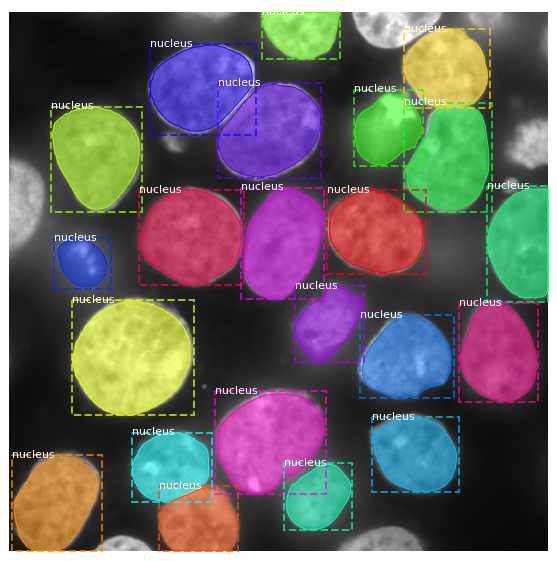

In [20]:
visualize.display_instances(img_hoechst_uint8, F_total_boxes, F_total_masks, F_total_class_ids, ["BG","nucleus"], figsize=(10,10))

### 4.3 mask processing

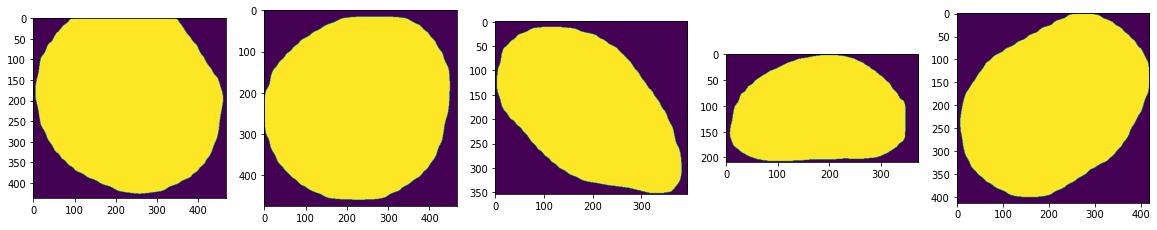

In [227]:
plt.figure(figsize=(20,20))
for nn in range(1,6):
    bb = F_total_boxes[nn]
    mmask = F_total_masks[:,:,nn][bb[0]:bb[2], bb[1]:bb[3]]

    plt.subplot(1,5,nn)
    plt.imshow(mmask)

# 5. Split Cell 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


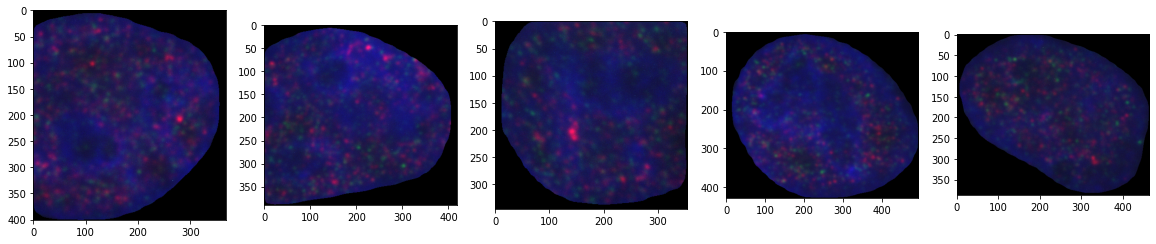

In [99]:
plt.figure(figsize=(20,20))
for nn in range(1,6):
    bb = F_total_boxes[nn]
    mmask = F_total_masks[:,:,nn][bb[0]:bb[2], bb[1]:bb[3]].astype(int)
    mmask = cv2.merge([mmask,mmask,mmask])
    iimg = img_origin[bb[0]:bb[2], bb[1]:bb[3]]
    iimg = np.multiply(iimg, mmask)
    
    plt.subplot(1,5,nn)
    plt.imshow(iimg)

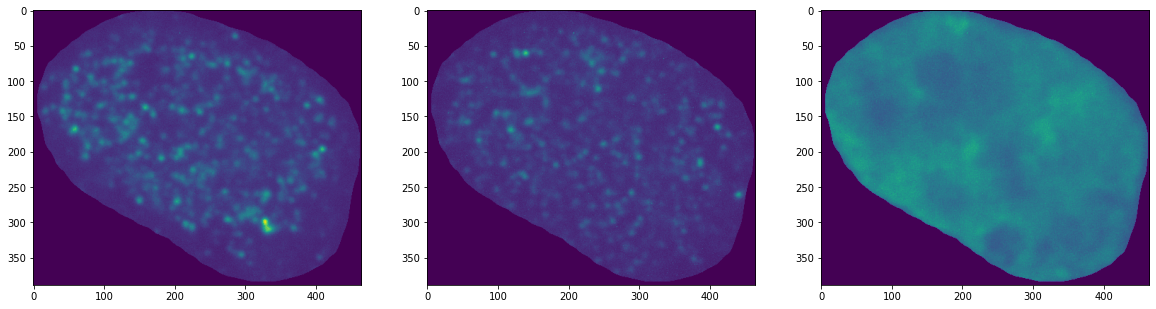

In [100]:
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(iimg[:,:,0])
plt.subplot(1,3,2)
plt.imshow(iimg[:,:,1])
plt.subplot(1,3,3)
plt.imshow(iimg[:,:,2])

## Install Required Packages

In [101]:
# GPU = True 
# !pip install scikit-image
# !pip install keras==2.2.5
# !pip uninstall -y tensorflow
# if GPU == True:
#     !pip install tensorflow-gpu==1.14
# else:
#     !pip install tensorflow==1.14 

## Download and Install Mask R-CNN

In [ ]:
# # Download Mask R-CNN
# if not os.path.exists('./root/Mask_RCNN'):
#     %cd ./root/
#     !git clone --quiet https://github.com/matterport/Mask_RCNN.git
#     %cd ./Mask_RCNN
# else:
#     %cd ./root/Mask_RCNN

# # Install Mask R-CNN
# !pip install -q PyDrive
# !python setup.py install
# !pip install colorspacious
# if not os.path.exists('./glasbey'):
#     !git clone --quiet https://github.com/taketwo/glasbey.git
# !pip install imagecodecs
# !pip install h5py==2.10.0


# %pwd